In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [12]:
training_dict = np.load("py3_training_dict.npy").item()

In [11]:
training_dict.keys()

dict_keys(['training_x', 'training_regress', 'training_class'])

In [13]:
training_x = training_dict['training_x']
training_regress = training_dict['training_regress']
training_class = training_dict['training_class']

In [14]:
mask = np.isnan(training_regress)

In [15]:
X = np.array(training_x)[~mask]
y = np.array(training_regress)[~mask]

In [16]:
test_X = np.expand_dims(X ,axis = 3)
tensor_X = tf.convert_to_tensor(test_X)

In [17]:
tensor_X

<tf.Tensor 'Const_1:0' shape=(778, 32, 32, 1) dtype=float64>

In [18]:
tensor_y = tf.convert_to_tensor(y)

In [19]:
tensor_X = tf.convert_to_tensor(test_X)

In [20]:
tensor_y

<tf.Tensor 'Const_2:0' shape=(778,) dtype=float64>

In [10]:
degree_y = np.rad2deg(y)

In [21]:
degree_y = np.expand_dims(y, axis=1)

In [22]:
degree_y.shape

(778, 1)

In [23]:
test_X.shape

(778, 32, 32, 1)

In [24]:
def cnn_model_fn(features, labels , mode):
    #input_layer = tf.reshape(X, [-1,32,32,1])
    #initializer = tf.variance_scaling_initializer(scale = 2.0)
    input_layer = tf.reshape(features["x"],[-1,32,32,1])
    out = tf.layers.conv2d(inputs = input_layer, filters= 64, kernel_size= [3,3], padding='same',\
                            activation=tf.nn.relu)
    #out = tf.layers.max_pooling2d(out, 2, 2, "same")
    out = tf.layers.conv2d(inputs = out, filters = 128, kernel_size = [3,3], \
                            padding = 'same', activation = tf.nn.relu)
    out = tf.layers.max_pooling2d(inputs = out, pool_size=[2,2],strides=2)
    out = tf.layers.dropout(inputs = out, rate = 0.25)
    out = tf.layers.flatten(inputs = out)
    out = tf.layers.dense(inputs = out, units= 128)
    out = tf.layers.dropout(inputs = out, rate = 0.25)
    out = tf.layers.dense(inputs = out, units = 64)
    pred_angle = tf.layers.dense(inputs = out, units = 1)
    
    predictions = {
        "angle": tf.identity(pred_angle,"angle_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions = predictions)
    
    loss = tf.losses.mean_squared_error(labels = labels, predictions = pred_angle)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        #SGD is a terrible optimizer ! need to change to another one
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss = loss, 
                                     global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode = mode, loss = loss, train_op = train_op)
    
    eval_metric_ops = {
        "mean_absolute_error": tf.metrics.mean_absolute_error(labels= labels, predictions= pred_angle)
    }
    return tf.estimator.EstimatorSpec(mode = mode, loss = loss, eval_metric_ops = eval_metric_ops)
    

In [25]:
def train_model():
    angle_regressor = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir= "/home/zhejun/Neural_Networks/particle_orientation_training_build/regress_test2")
    tensors_to_log = {"angle": "angle_tensor"}
    logging_hook = tf.train.LoggingTensorHook(tensors= tensors_to_log, every_n_iter= 50)
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = {"x": test_X},
        y = degree_y,
        batch_size= 100,
        num_epochs= None,
        shuffle= True
    )
    angle_regressor.train(
        input_fn=train_input_fn,
        steps = 10000,
        hooks=[logging_hook]
    )
    

In [26]:
def eval_mode():
    angle_regressor = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir= "/home/zhejun/Neural_Networks/particle_orientation_training_build/regress_test2")
    tensors_to_log = {"angle": "angle_tensor"}
    logging_hook = tf.train.LoggingTensorHook(tensors= tensors_to_log, every_n_iter= 50)
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x":test_X},
        y=degree_y,
        num_epochs=1,
        shuffle=False
    )
    eval_results = angle_regressor.evaluate(input_fn=eval_input_fn)
    print(eval_results)

In [27]:
train_model()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/home/zhejun/Neural_Networks/particle_orientation_training_build/regress_test2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f400a2d57b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` modu

INFO:tensorflow:global_step/sec: 6.70953
INFO:tensorflow:angle = [[ 0.22607544]
 [ 1.19807019]
 [ 1.61314951]
 [ 5.22709511]
 [ 3.88944126]
 [ 3.43393382]
 [ 0.68026108]
 [ 5.53960558]
 [ 2.88900681]
 [ 0.97079225]
 [ 1.77389355]
 [ 5.23679828]
 [ 2.63116221]
 [ 0.76805681]
 [ 4.18035621]
 [ 5.11936427]
 [ 4.81181103]
 [ 2.85158799]
 [ 3.20407051]
 [ 3.98279397]
 [ 2.8990988 ]
 [ 4.75819161]
 [ 0.49063716]
 [ 4.48227513]
 [ 3.36695999]
 [ 0.6230423 ]
 [ 0.43701498]
 [ 3.66087552]
 [ 1.07179308]
 [ 0.73946827]
 [ 2.31849512]
 [ 4.55418862]
 [ 2.45531343]
 [ 0.80147989]
 [ 3.42828299]
 [ 2.82146894]
 [ 1.40925769]
 [ 0.66491374]
 [ 3.30867702]
 [ 4.16450362]
 [ 4.42987314]
 [ 1.61473033]
 [ 5.85510173]
 [ 2.16375606]
 [ 3.11769005]
 [ 3.08610593]
 [ 4.04186518]
 [ 1.40925769]
 [ 3.88751642]
 [ 5.61367075]
 [ 1.37438436]
 [ 0.12488649]
 [ 3.47825001]
 [ 0.57569748]
 [ 4.95619229]
 [ 0.848043  ]
 [-0.1825691 ]
 [ 2.8987095 ]
 [ 4.35938494]
 [ 5.41340069]
 [ 4.2287682 ]
 [ 3.53939441]
 [ 4.

INFO:tensorflow:global_step/sec: 6.64972
INFO:tensorflow:angle = [[3.28159464]
 [1.31642422]
 [0.79584776]
 [4.84814953]
 [3.43030537]
 [6.67401603]
 [2.49552146]
 [1.70241295]
 [0.70392707]
 [0.26628564]
 [2.11471793]
 [2.02425949]
 [6.84603348]
 [3.43030537]
 [1.56517439]
 [2.94928811]
 [2.22304341]
 [2.60189078]
 [1.18833694]
 [5.31145044]
 [1.88145986]
 [1.86719853]
 [5.60920153]
 [5.53030465]
 [5.08940892]
 [2.45885833]
 [2.4306284 ]
 [2.51507027]
 [5.76844693]
 [2.74543155]
 [5.3403083 ]
 [0.96307165]
 [0.7738085 ]
 [0.79299667]
 [6.05797462]
 [6.43272889]
 [6.58234002]
 [2.07452458]
 [0.54744502]
 [1.34105652]
 [2.16388106]
 [2.79361094]
 [0.8882448 ]
 [0.79299667]
 [2.98597427]
 [6.18568975]
 [0.92155395]
 [2.71062953]
 [4.87850643]
 [5.74339318]
 [0.76449312]
 [4.93959645]
 [2.64896538]
 [5.02055173]
 [0.62043038]
 [1.8044389 ]
 [0.65410041]
 [4.17252858]
 [5.69927907]
 [2.44474827]
 [4.88815173]
 [3.95395481]
 [4.61040209]
 [1.20794282]
 [5.95436861]
 [6.04942453]
 [3.3949315

INFO:tensorflow:global_step/sec: 6.60349
INFO:tensorflow:angle = [[2.2001828 ]
 [4.50525687]
 [3.4404627 ]
 [5.94076513]
 [4.54351765]
 [0.32432021]
 [5.55901578]
 [5.06405615]
 [4.40224719]
 [3.58368399]
 [5.77711237]
 [5.74445503]
 [2.12025835]
 [4.07104311]
 [2.02330747]
 [4.14521117]
 [0.66513197]
 [0.45866399]
 [4.82477022]
 [1.41617171]
 [5.95779062]
 [2.59635948]
 [3.36275658]
 [4.94056016]
 [4.0646509 ]
 [0.93804452]
 [0.49190264]
 [3.67882856]
 [0.95832841]
 [0.87336155]
 [1.65643825]
 [0.73685088]
 [0.5632969 ]
 [0.88615136]
 [0.92613116]
 [1.61214404]
 [1.18358957]
 [0.41187898]
 [1.53118914]
 [0.78214961]
 [4.67204586]
 [2.09536735]
 [0.01002407]
 [4.60751009]
 [4.39932005]
 [0.14456358]
 [4.42020279]
 [3.43675371]
 [2.48926934]
 [3.03921073]
 [4.60751009]
 [3.02654026]
 [0.7846411 ]
 [1.03081275]
 [5.48917084]
 [1.19345399]
 [3.15619155]
 [4.79836722]
 [0.64002578]
 [5.73540669]
 [3.27516036]
 [3.84012184]
 [4.6816733 ]
 [0.68648286]
 [5.05167885]
 [4.99979649]
 [2.3972177

INFO:tensorflow:global_step/sec: 6.5573
INFO:tensorflow:angle = [[ 1.10276241]
 [ 6.09118218]
 [ 2.39940963]
 [ 1.86135651]
 [ 1.47466994]
 [ 4.16397641]
 [ 0.09761697]
 [ 4.97498277]
 [ 2.35536572]
 [ 1.45120962]
 [ 0.28349188]
 [ 4.23399565]
 [ 1.3405895 ]
 [ 0.6487851 ]
 [ 6.24647341]
 [ 5.06060805]
 [ 6.00926535]
 [ 5.53241836]
 [ 1.03341425]
 [ 3.49574311]
 [ 3.77008064]
 [ 3.39082494]
 [ 3.25236016]
 [ 2.03557326]
 [ 6.07689835]
 [ 6.07689835]
 [ 1.58772193]
 [ 5.43074621]
 [ 4.241705  ]
 [ 3.78528599]
 [ 2.16849559]
 [ 0.59935553]
 [ 0.74775857]
 [ 4.374717  ]
 [ 5.89409091]
 [ 2.2039383 ]
 [ 0.53720708]
 [ 1.3613759 ]
 [ 0.37772295]
 [ 3.59347411]
 [ 5.96474866]
 [ 3.58707531]
 [ 0.17770844]
 [ 4.74270664]
 [ 3.26587022]
 [ 1.3613759 ]
 [ 4.96444712]
 [ 2.13777167]
 [ 1.35448575]
 [ 1.21769199]
 [ 5.73418086]
 [ 4.70488699]
 [ 1.59652029]
 [ 5.99138431]
 [ 2.2039383 ]
 [ 4.79801969]
 [ 0.37909725]
 [ 1.84916388]
 [ 1.94653404]
 [ 1.71631165]
 [ 5.73913697]
 [ 0.8487861 ]
 [ 2.9

INFO:tensorflow:global_step/sec: 6.57165
INFO:tensorflow:angle = [[4.91661631]
 [1.33677432]
 [0.353731  ]
 [0.76156073]
 [4.0719657 ]
 [5.71513781]
 [4.38817378]
 [0.44680962]
 [5.62755899]
 [6.14984042]
 [0.5806589 ]
 [0.35526814]
 [5.5854306 ]
 [1.94047856]
 [5.4484085 ]
 [4.14804002]
 [6.11641781]
 [0.78078661]
 [6.32369024]
 [1.44425399]
 [4.2490254 ]
 [3.99657256]
 [3.32533874]
 [2.44126755]
 [5.34042217]
 [1.73965906]
 [3.2609419 ]
 [1.56831152]
 [1.52618907]
 [4.75680179]
 [3.32533874]
 [4.38817378]
 [2.08790995]
 [4.42069486]
 [3.57335496]
 [5.288255  ]
 [1.81228313]
 [1.27541487]
 [0.93419401]
 [1.96475376]
 [4.0719657 ]
 [0.84692993]
 [3.73495068]
 [3.55229859]
 [2.50012231]
 [0.37931897]
 [2.55510293]
 [1.27002477]
 [0.66427363]
 [0.68243242]
 [1.14192483]
 [0.28060259]
 [1.8809175 ]
 [5.17271888]
 [3.20773255]
 [0.42404413]
 [4.83833913]
 [0.71484012]
 [1.19546866]
 [2.09426997]
 [0.5597232 ]
 [3.01714351]
 [4.03346024]
 [0.85800508]
 [3.78805321]
 [5.68447809]
 [0.3192501

INFO:tensorflow:global_step/sec: 6.52884
INFO:tensorflow:angle = [[0.64521832]
 [3.78267567]
 [4.43804865]
 [2.67063866]
 [0.64894944]
 [1.04472262]
 [3.04267944]
 [1.2933329 ]
 [4.94279018]
 [3.27815709]
 [5.36284057]
 [1.89509021]
 [6.71648938]
 [3.00317546]
 [3.82367122]
 [1.99195444]
 [3.4447047 ]
 [2.93113477]
 [6.04489542]
 [5.04349658]
 [4.93794451]
 [3.61545691]
 [2.28244202]
 [3.44705228]
 [5.36445127]
 [1.51577704]
 [5.78261234]
 [0.37922464]
 [5.05338058]
 [1.54875909]
 [4.32415859]
 [1.2797623 ]
 [5.29906532]
 [5.50096942]
 [3.3587979 ]
 [4.65210812]
 [2.66380768]
 [3.92570639]
 [0.76818043]
 [5.90189806]
 [1.1878233 ]
 [5.71305592]
 [4.88194225]
 [5.54990775]
 [1.92756499]
 [5.28474607]
 [1.31286689]
 [0.36827251]
 [3.72510358]
 [2.84157253]
 [5.81542479]
 [3.65778743]
 [3.4598771 ]
 [2.52345788]
 [1.33745062]
 [5.18451395]
 [2.68736283]
 [5.8284683 ]
 [3.75139112]
 [1.2427738 ]
 [1.24881965]
 [4.39645879]
 [5.47138148]
 [1.03804442]
 [4.38281679]
 [2.95820645]
 [5.1597499

INFO:tensorflow:global_step/sec: 6.54414
INFO:tensorflow:angle = [[ 0.29032264]
 [ 5.43487724]
 [ 3.34767565]
 [ 3.92777565]
 [ 4.30847855]
 [ 3.19758351]
 [ 3.19970584]
 [ 5.49733566]
 [ 3.59064623]
 [ 3.41755838]
 [ 1.61552316]
 [ 1.4924252 ]
 [ 5.18850254]
 [ 4.59936753]
 [ 4.03625244]
 [ 1.61934328]
 [ 0.25589368]
 [ 2.76032416]
 [ 4.0797594 ]
 [ 1.02495537]
 [ 3.01549213]
 [ 6.05378635]
 [ 3.78434452]
 [ 4.04077174]
 [ 4.27712228]
 [ 2.22462064]
 [ 0.40910786]
 [ 5.89880661]
 [ 2.65399195]
 [ 4.85177381]
 [ 4.21777139]
 [ 1.18312087]
 [ 0.13849313]
 [ 1.79399943]
 [ 2.52308149]
 [ 0.29032264]
 [ 2.98413722]
 [ 0.7486315 ]
 [ 0.52825977]
 [ 5.56667302]
 [ 5.43122052]
 [ 0.76856198]
 [ 3.13215006]
 [ 5.33695236]
 [ 4.79459059]
 [-0.02308469]
 [ 4.66305   ]
 [ 0.6057605 ]
 [ 5.80938141]
 [ 0.60891836]
 [ 3.23975021]
 [ 3.58107488]
 [ 0.29983156]
 [ 3.34767565]
 [ 3.31780917]
 [ 4.6387013 ]
 [ 1.68658529]
 [ 5.68875497]
 [ 5.42781166]
 [ 3.1087396 ]
 [ 2.14345615]
 [ 4.18150383]
 [ 5.

INFO:tensorflow:global_step/sec: 6.56172
INFO:tensorflow:angle = [[ 1.03567584]
 [ 2.83796698]
 [ 4.69759835]
 [ 5.67853878]
 [ 1.31426682]
 [-0.12251342]
 [-0.21694119]
 [ 5.19029255]
 [ 5.61575369]
 [ 3.61849561]
 [ 2.21363906]
 [ 6.0892527 ]
 [ 0.46786771]
 [ 5.55343927]
 [ 5.39111131]
 [ 5.92935557]
 [ 2.81463221]
 [ 1.69558274]
 [ 2.61175154]
 [ 3.14704699]
 [-0.12251342]
 [ 5.4962075 ]
 [ 1.70856546]
 [ 2.70498823]
 [ 5.00998893]
 [ 0.41051178]
 [ 1.32894798]
 [ 3.33065896]
 [ 0.74329961]
 [ 4.91258115]
 [ 1.03773766]
 [ 2.30773174]
 [ 4.78109606]
 [ 3.15453013]
 [ 0.12736279]
 [ 3.19054558]
 [ 0.69209496]
 [ 4.51744915]
 [ 4.07947684]
 [ 6.14589215]
 [ 3.95334115]
 [ 4.2901369 ]
 [ 5.21457939]
 [ 2.25042963]
 [ 0.86214674]
 [ 3.56951731]
 [ 4.04581488]
 [ 0.92109448]
 [ 3.94495526]
 [ 3.14841439]
 [ 0.58674376]
 [ 5.43603352]
 [ 4.29675934]
 [ 0.90538756]
 [ 4.6011909 ]
 [ 6.10398581]
 [ 3.84791547]
 [ 3.30402245]
 [ 0.47503033]
 [ 2.55405916]
 [ 1.5088556 ]
 [ 0.388117  ]
 [ 2.

INFO:tensorflow:global_step/sec: 6.56105
INFO:tensorflow:angle = [[1.70443289]
 [2.66952216]
 [1.21405091]
 [3.30342477]
 [4.76655406]
 [0.43187487]
 [1.69695716]
 [2.24694201]
 [0.12515697]
 [0.53761005]
 [2.98294145]
 [5.23537803]
 [5.59167909]
 [5.03244153]
 [6.47880978]
 [5.01982829]
 [2.30936706]
 [5.30023018]
 [0.95207325]
 [5.03492962]
 [4.11388434]
 [4.34471245]
 [3.43649898]
 [0.29517916]
 [2.34006577]
 [2.12460858]
 [3.41684767]
 [6.29694996]
 [3.80489933]
 [4.43628044]
 [4.94543288]
 [4.81055101]
 [0.93257725]
 [0.48689123]
 [1.11547873]
 [3.56396232]
 [5.49382675]
 [4.94952559]
 [5.91100563]
 [1.47002089]
 [3.16397185]
 [3.41684767]
 [1.63396509]
 [4.84966992]
 [1.59650579]
 [3.34324589]
 [4.96628685]
 [4.26509106]
 [0.64133308]
 [3.43480341]
 [3.94162897]
 [4.95971403]
 [0.68062237]
 [0.77856849]
 [3.72894806]
 [2.12460858]
 [3.3940689 ]
 [0.77291111]
 [0.64947476]
 [4.67802299]
 [4.7513632 ]
 [1.03443077]
 [1.27263988]
 [5.84376802]
 [1.72229295]
 [6.43953857]
 [1.7206413

INFO:tensorflow:loss = 0.04266175, step = 12277 (15.265 sec)
INFO:tensorflow:angle = [[ 0.22300387]
 [ 5.36570016]
 [ 1.03938045]
 [ 0.25258202]
 [ 2.34804796]
 [ 4.99429678]
 [ 6.12381426]
 [ 0.55389956]
 [ 0.79567912]
 [ 3.20770595]
 [ 0.85653604]
 [ 6.25430349]
 [ 4.26249445]
 [ 2.25077807]
 [ 6.14538062]
 [ 6.28673197]
 [ 6.01269697]
 [ 2.90821137]
 [ 0.2700146 ]
 [ 2.4355536 ]
 [ 0.70196095]
 [ 5.15715111]
 [ 4.77770765]
 [ 5.04285948]
 [ 4.65074687]
 [ 3.73773875]
 [ 3.87825101]
 [ 3.30367305]
 [ 5.03980578]
 [ 2.03911449]
 [ 1.00402563]
 [ 0.03035077]
 [ 2.05377078]
 [ 0.42218105]
 [ 3.55271728]
 [ 5.41162587]
 [ 4.69115916]
 [ 5.61483181]
 [ 4.37342576]
 [ 5.03980578]
 [ 3.63418867]
 [ 5.98085658]
 [ 1.81156213]
 [ 2.90821137]
 [-0.1086111 ]
 [ 2.62432719]
 [ 3.19386867]
 [ 4.11859467]
 [ 0.80337923]
 [ 2.58167477]
 [ 1.20877508]
 [ 6.11060397]
 [ 4.89640525]
 [ 4.95331421]
 [ 0.22330182]
 [ 4.38213816]
 [ 2.5819779 ]
 [ 2.40462013]
 [ 0.46201706]
 [ 5.08038307]
 [ 3.68471104]


INFO:tensorflow:loss = 0.07037986, step = 12577 (15.205 sec)
INFO:tensorflow:angle = [[1.01587402]
 [2.58169614]
 [0.09777724]
 [3.42643834]
 [6.08518165]
 [1.54421156]
 [0.48662269]
 [2.03242972]
 [1.22624476]
 [1.79387108]
 [0.5489882 ]
 [0.73338073]
 [1.86096549]
 [1.86573944]
 [3.96019385]
 [4.91625368]
 [0.72602279]
 [0.88292238]
 [0.83857918]
 [5.45902185]
 [6.3640316 ]
 [5.84026642]
 [1.62655771]
 [4.34249413]
 [0.84219779]
 [0.71847751]
 [2.56211035]
 [0.61324929]
 [3.38824785]
 [4.96639494]
 [1.52657806]
 [1.70102311]
 [1.6807863 ]
 [2.82732143]
 [1.97802467]
 [1.70968064]
 [1.25521681]
 [3.62675109]
 [2.32440614]
 [3.57414474]
 [2.28511611]
 [6.36293324]
 [1.41522047]
 [1.48140286]
 [1.02927302]
 [1.38472587]
 [6.00619407]
 [3.40688869]
 [5.60087582]
 [0.88745871]
 [1.39906494]
 [4.18394695]
 [3.26013887]
 [5.33528394]
 [1.25006564]
 [3.25907771]
 [2.40063764]
 [1.77907083]
 [1.79387108]
 [4.68559234]
 [0.734456  ]
 [3.67743773]
 [0.41176106]
 [4.02413358]
 [4.81046822]
 [2.8

INFO:tensorflow:loss = 0.03618688, step = 12877 (15.262 sec)
INFO:tensorflow:angle = [[ 5.39276619]
 [ 1.24058205]
 [ 2.05418325]
 [ 5.45510668]
 [ 1.61990986]
 [ 5.76660164]
 [ 2.8683778 ]
 [ 6.12702685]
 [ 6.31504638]
 [ 3.21475448]
 [ 2.29452929]
 [ 5.1120744 ]
 [ 1.61083937]
 [ 5.62873672]
 [ 1.64734056]
 [ 3.3524185 ]
 [ 4.07504983]
 [ 4.58792616]
 [ 1.45740105]
 [ 3.20486056]
 [ 5.14181443]
 [ 4.89248712]
 [ 5.63601006]
 [ 6.0653697 ]
 [ 0.63778504]
 [ 3.13273054]
 [ 0.35267095]
 [ 4.4047532 ]
 [ 3.3292502 ]
 [ 2.15238992]
 [ 1.90462137]
 [ 1.6742982 ]
 [ 0.97343011]
 [ 0.24550605]
 [ 1.35590317]
 [ 4.60782425]
 [ 1.16720444]
 [ 2.66641954]
 [ 0.5127562 ]
 [ 6.03801133]
 [ 5.21112337]
 [ 0.90489751]
 [ 2.55359001]
 [ 1.74344203]
 [ 2.08472173]
 [ 3.82173361]
 [ 6.27583003]
 [ 1.91525621]
 [ 1.58431186]
 [ 4.73750816]
 [ 4.31450818]
 [ 4.92947461]
 [ 0.54456012]
 [ 4.27573844]
 [ 2.19976855]
 [ 3.19619824]
 [ 2.52420342]
 [ 0.2567278 ]
 [ 1.7227002 ]
 [ 3.30071294]
 [ 5.70526491]


INFO:tensorflow:loss = 0.13684191, step = 13177 (15.263 sec)
INFO:tensorflow:angle = [[3.75961197]
 [2.42795783]
 [5.67666181]
 [5.17481447]
 [5.68390562]
 [0.60187936]
 [4.34311449]
 [3.47252063]
 [2.49874207]
 [0.41791852]
 [5.97338062]
 [2.62416793]
 [2.4134313 ]
 [2.9717432 ]
 [0.77259842]
 [3.43668551]
 [3.30368076]
 [3.39209264]
 [2.07594389]
 [0.48701125]
 [1.68923624]
 [3.51207313]
 [0.99361215]
 [4.32169131]
 [0.67401414]
 [0.27925606]
 [3.60861146]
 [5.88870411]
 [6.16453215]
 [0.17588771]
 [1.60422518]
 [3.5845437 ]
 [4.87749759]
 [5.18118029]
 [0.6827434 ]
 [6.20391649]
 [0.80713724]
 [2.57356789]
 [0.78543679]
 [0.3864841 ]
 [0.74384651]
 [5.61276845]
 [2.81039421]
 [4.69575676]
 [1.03420857]
 [5.93733774]
 [2.03377536]
 [1.6094296 ]
 [3.91825981]
 [6.410593  ]
 [4.39970939]
 [6.31757028]
 [4.73288235]
 [4.36648147]
 [5.22407964]
 [3.99134272]
 [2.31972017]
 [1.1981074 ]
 [0.71113826]
 [3.17869946]
 [1.75568697]
 [4.539514  ]
 [5.9352335 ]
 [4.42506629]
 [3.88032547]
 [1.2

INFO:tensorflow:loss = 0.11899574, step = 13477 (15.306 sec)
INFO:tensorflow:angle = [[ 2.95372861]
 [ 5.46129176]
 [ 4.2359748 ]
 [ 0.69193303]
 [ 2.79230169]
 [ 2.03152364]
 [ 1.61214596]
 [ 4.24053532]
 [ 0.2853088 ]
 [ 0.42821161]
 [ 3.62734535]
 [ 1.1376795 ]
 [ 5.42551165]
 [ 5.51592963]
 [-0.28685878]
 [ 1.56475557]
 [ 0.41610308]
 [ 2.10569911]
 [ 1.48653707]
 [ 0.87171742]
 [ 2.17536205]
 [ 3.62248954]
 [ 5.72954464]
 [ 0.20733953]
 [ 5.79450319]
 [ 1.15539142]
 [ 5.93483484]
 [ 5.05750975]
 [ 1.9050667 ]
 [ 4.68885925]
 [ 3.62863452]
 [ 2.26395072]
 [ 4.24095629]
 [ 2.47478726]
 [ 1.26226521]
 [ 1.42455414]
 [ 1.59323655]
 [ 4.59183464]
 [ 4.37212357]
 [ 5.79450319]
 [-0.10474503]
 [ 5.98543648]
 [ 1.03220823]
 [-0.25715568]
 [ 0.01897242]
 [ 3.4017131 ]
 [ 3.1673977 ]
 [ 4.54293077]
 [ 4.98273662]
 [ 4.60090446]
 [ 3.13927423]
 [ 2.23703578]
 [ 5.13881573]
 [-0.17873805]
 [ 5.18337412]
 [ 2.01817494]
 [ 1.04206219]
 [ 1.49813382]
 [ 5.12996161]
 [ 5.40353041]
 [ 3.03600281]


INFO:tensorflow:loss = 0.17713194, step = 13777 (15.225 sec)
INFO:tensorflow:angle = [[ 0.49760026]
 [ 2.02696522]
 [ 2.58226626]
 [ 6.17677671]
 [ 6.0342698 ]
 [ 3.2360434 ]
 [ 3.79968155]
 [ 2.2654945 ]
 [ 3.47372527]
 [ 3.32193873]
 [ 3.84598783]
 [ 4.45479656]
 [ 1.22492932]
 [ 0.48391128]
 [ 3.30673667]
 [ 5.50530107]
 [ 1.89683146]
 [ 2.11198434]
 [ 0.24190371]
 [ 0.90507029]
 [ 1.05747792]
 [ 3.48124634]
 [ 1.61832822]
 [ 1.90990493]
 [ 1.31672851]
 [ 3.50603107]
 [ 6.07875   ]
 [ 2.82246011]
 [ 5.7892712 ]
 [ 1.96349826]
 [ 0.1055556 ]
 [ 5.44344841]
 [ 0.20481051]
 [ 3.73327838]
 [ 4.16626311]
 [ 5.65125163]
 [ 1.75640618]
 [ 3.39165432]
 [ 4.58703812]
 [ 3.48124634]
 [ 4.43791922]
 [ 0.14506985]
 [ 5.62165688]
 [ 6.14581349]
 [ 1.67799241]
 [ 4.4229219 ]
 [ 2.98824475]
 [ 2.07988791]
 [ 6.14659344]
 [ 0.03436508]
 [ 4.94124094]
 [ 3.68010938]
 [ 0.32739947]
 [ 5.63419235]
 [ 2.06335192]
 [ 1.4358013 ]
 [ 0.64996412]
 [ 1.76568373]
 [ 5.23343465]
 [ 1.80329186]
 [ 0.61938505]


KeyboardInterrupt: 

In [28]:
eval_mode()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/home/zhejun/Neural_Networks/particle_orientation_training_build/regress_test2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f400818d9b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:t

In [16]:
train_model()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/home/zhejun/Neural_Networks/particle_orientation_training_build/regress_test', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1ba40379b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` modul

INFO:tensorflow:global_step/sec: 14.3839
INFO:tensorflow:angle = [[3.20179358]
 [2.91193293]
 [1.37862316]
 [1.50929595]
 [2.4443231 ]
 [3.21005637]
 [3.93179241]
 [2.0590229 ]
 [2.33675298]
 [2.96150163]
 [1.943808  ]
 [2.33675298]
 [3.27818601]
 [2.76749776]
 [1.49597301]
 [2.40573887]
 [1.80317261]
 [2.25548704]
 [2.8658694 ]
 [3.40555611]
 [2.87763533]
 [1.78895331]
 [1.72760488]
 [2.28152688]
 [2.55633792]
 [3.18124406]
 [2.41410992]
 [1.99823266]
 [2.44272456]
 [1.88662261]
 [2.1354776 ]
 [2.14215927]
 [1.39122268]
 [3.11000384]
 [2.9648286 ]
 [2.86614285]
 [2.57015918]
 [2.51373555]
 [3.0001917 ]
 [2.36601403]
 [2.4972931 ]
 [2.71312482]
 [2.83473892]
 [2.38316335]
 [2.75084517]
 [2.93618996]
 [1.26680574]
 [3.11548424]
 [3.68749892]
 [2.15071446]] (3.461 sec)
INFO:tensorflow:loss = 2.9772878, step = 400 (6.953 sec)
INFO:tensorflow:angle = [[2.30394534]
 [3.25632785]
 [1.8214849 ]
 [2.80335046]
 [3.67722831]
 [2.07283869]
 [1.95863833]
 [3.6683185 ]
 [2.61738971]
 [2.31670793]
 

INFO:tensorflow:loss = 1.9426062, step = 900 (6.941 sec)
INFO:tensorflow:angle = [[ 2.7500953 ]
 [ 3.01184247]
 [ 0.84590802]
 [ 2.07673437]
 [ 2.29093357]
 [ 2.49300215]
 [ 2.93479487]
 [ 4.25548417]
 [ 2.27704779]
 [ 5.44177754]
 [ 0.98599051]
 [ 0.61644877]
 [ 1.12160877]
 [ 0.0475272 ]
 [ 2.57745308]
 [ 1.71534086]
 [ 2.87843102]
 [ 3.91522599]
 [ 3.49100167]
 [ 0.86830122]
 [ 0.81982842]
 [ 4.25565659]
 [ 2.226079  ]
 [ 3.36539473]
 [ 3.60102639]
 [ 5.16108656]
 [ 3.37522088]
 [ 1.83115701]
 [ 5.01559483]
 [ 4.37694876]
 [ 1.88799681]
 [ 2.50586566]
 [ 4.20911557]
 [ 2.29721025]
 [ 0.6338623 ]
 [ 3.00318181]
 [ 1.62807219]
 [ 4.18965134]
 [ 3.90768248]
 [ 3.15625497]
 [ 2.4702483 ]
 [ 2.53955556]
 [ 2.72602151]
 [-0.01112499]
 [ 4.15899221]
 [ 1.37975786]
 [ 1.08754162]
 [ 1.05578255]
 [ 2.01875988]
 [ 2.35878562]] (3.396 sec)
INFO:tensorflow:Saving checkpoints for 1000 into /home/zhejun/Neural_Networks/particle_orientation_training_build/regress_test/model.ckpt.
INFO:tensorflow:L

In [42]:
degree_y.shape

(778,)

In [33]:
degree_y = np.rad2deg(y)

In [8]:
initializer = tf.variance_scaling_initializer(scale = 2.0)

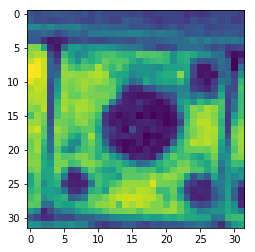

In [12]:
plt.imshow(X[0])

In [34]:
mask = np.isnan(training_regress)

In [35]:
regress_x = np.array(training_x)[~mask]

In [36]:
regress_y = np.array(training_regress)[~mask]

In [18]:
len(regress_y)

778

(array([98., 86., 81., 86., 54., 81., 61., 71., 80., 80.]),
 array([4.70829010e-03, 6.32456589e-01, 1.26020489e+00, 1.88795319e+00,
        2.51570148e+00, 3.14344978e+00, 3.77119808e+00, 4.39894638e+00,
        5.02669468e+00, 5.65444298e+00, 6.28219128e+00]),
 <a list of 10 Patch objects>)

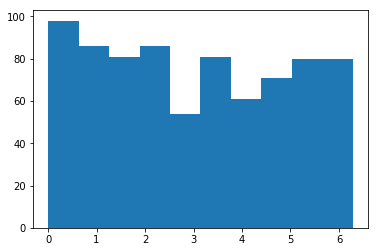

In [37]:
plt.hist(regress_y)